In [143]:
import pandas as pd 
import numpy as np
from datetime import datetime
from typing import Tuple
import warnings
warnings.filterwarnings('ignore')

base_path = 'D:/dneuro/research/'
output_path = 'D:/dneuro/research/output/summary/'

df_index = pd.read_excel(base_path + '/tpx500_historical_total_return_2000_2025.xlsx', index_col = 0)
df_price = pd.read_pickle(base_path + '/tpx500_last_price_data_20250213.pkl')
df_return = pd.read_pickle(base_path + '/tpx500_historical_total_return_2000_2025_0213.pkl')
df_historical_index = pd.read_pickle(base_path + '/tpx500_constituents_20000101_20250213.pkl')
df_volume = pd.read_pickle(base_path + '/tpx500_trading_volume_data_20250213.pkl')
df_cur_mkt_cap = pd.read_pickle(base_path + '/tpx500_cur_mkt_cap_data_20250213.pkl')
df_free_float = pd.read_pickle(base_path + '/tpx500_free_float_real_20250220.pkl')
df_fx = pd.read_pickle(base_path + '/tpx500_msfxjpy_index_price_2000_2025.pkl')

df_price = df_price.reindex(sorted(df_price.columns, key=str), axis=1)
df_volume = df_volume.reindex(sorted(df_volume.columns, key=str), axis=1)
df_return = df_return.reindex(sorted(df_return.columns, key=str), axis=1)
df_free_float = df_free_float.reindex(sorted(df_free_float.columns, key=str), axis=1)

df_fx.columns = ['MSFXJPY Index']
df_fx['pct_change'] = df_fx['MSFXJPY Index'].pct_change()

def calculateBeta(stockData: pd.DataFrame, marketData: pd.DataFrame, evaluation_date: float, rolling_period: int) -> float:
    stockData.index = pd.to_datetime(stockData.index)
    marketData.index = pd.to_datetime(marketData.index)
    eval_date = datetime.strptime(str(int(evaluation_date)),'%Y%m%d')
    common_dates = list(stockData.index.intersection(marketData.index))
    common_dates = [a for a in common_dates if a <= eval_date]
    if len(common_dates) >= rolling_period:
        common_dates = common_dates[-rolling_period:]
        stockData = stockData[stockData.index.isin(common_dates)]
        marketData = marketData[marketData.index.isin(common_dates)]
        covariance = np.cov(stockData[1:].values.flatten(), marketData[1:].values.flatten())
        variance = np.var(marketData[1:].values.flatten())
        return covariance[0,1] / variance
    else:
        return np.nan

def calculate_beta_adjusted_return(fundData: pd.DataFrame, marketData: pd.DataFrame, rolling_period: int) -> float:
    fundData.index = pd.to_datetime(fundData.index)
    marketData.index = pd.to_datetime(marketData.index)
   
    common_dates = list(fundData.index.intersection(marketData.index))
    
    adj_fund_data_lst = []
    beta_lst = []
    
    for x in range(len(common_dates)):

        if x < rolling_period - 1:

            beta = 1
            adj_fund_data_lst.append(fundData.loc[common_dates[x]] / beta)
            beta_lst.append(beta)

        else:

            spot_beta_period = common_dates[x - rolling_period + 1:x+1]
        
            fund_spot_data = fundData[fundData.index.isin(spot_beta_period)]
            market_spot_data = marketData[marketData.index.isin(spot_beta_period)]
            covariance = np.cov(fund_spot_data.values.flatten(), market_spot_data.values.flatten())
            variance = np.var(market_spot_data.values.flatten())
            beta = covariance[0,1] / variance
            adj_fund_data_lst.append(fund_spot_data.loc[common_dates[x]] / beta)
            beta_lst.append(beta)

    df_adj_stock_data = pd.DataFrame(adj_fund_data_lst, index = common_dates) 
    df_beta = pd.DataFrame({'beta': beta_lst}, index = common_dates)
    return df_beta

def build_usd_return(df_fx: pd.DataFrame, df_return: pd.DataFrame) -> pd.DataFrame:

    common_dates = df_fx.index.intersection(df_return.index)

    df_fx_filtered = df_fx.loc[common_dates]

    df_return_filtered = df_return.loc[common_dates]

    tickers = df_return.columns.tolist()
    df_fx_filtered['pct_change_plus_1'] = df_fx_filtered['pct_change'] + 1

    df_return_filtered = (1+df_return_filtered).multiply(df_fx_filtered['pct_change_plus_1'], axis=0) - 1
    df_return_filtered = df_return_filtered[tickers]
    return df_return_filtered


def build_same_setting_dataframe(df_a: pd.DataFrame, df_b: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]: 
    # Find common tickers using set intersection (faster than list comprehension)
    common_tickers = sorted(set(df_a.columns) & set(df_b.columns))

    # Select only common tickers in sorted order
    return df_a[common_tickers], df_b[common_tickers]

def build_quantile_filtered_dataframe(df_factor: pd.DataFrame, quantile: float, method: str) -> pd.DataFrame:

    df = pd.DataFrame()
    for i in range(len(df_factor)):

        df_factor_spot = pd.DataFrame(df_factor.iloc[i])
        if method == '<':
            df_factor_spot_filtered = df_factor_spot[df_factor_spot < df_factor_spot.quantile(1-quantile)].T
           
        elif method == '>=':
            df_factor_spot_filtered = df_factor_spot[df_factor_spot >= df_factor_spot.quantile(quantile)].T

        df_factor_spot_filtered_dropna = df_factor_spot_filtered.dropna(axis=1)
        # factor_spot_tickers = (df_factor_spot_filtered_dropna.columns.tolist())
        # print(df_factor.index[i],len(factor_spot_tickers))
        df = df._append(df_factor_spot_filtered)
    
    df.index.name = 'index'
    return df

def build_quantile_filtered_dataframe_ver2(df_factor: pd.DataFrame, quantile1: float, quantile2: float,method: str) -> pd.DataFrame:

    date_lst = []
    mean_lst = []
    df = pd.DataFrame()
    for i in range(len(df_factor)):

        df_factor_spot = pd.DataFrame(df_factor.iloc[i])
        if method == '<':
            df_factor_spot_filtered = df_factor_spot[(df_factor_spot < df_factor_spot.quantile(1-quantile1)) & (df_factor_spot >= df_factor_spot.quantile(1-quantile2))].T
           
        elif method == '>=':
            df_factor_spot_filtered = df_factor_spot[(df_factor_spot >= df_factor_spot.quantile(quantile1)) & (df_factor_spot < df_factor_spot.quantile(quantile2))].T

        df_factor_spot_filtered_dropna = df_factor_spot_filtered.dropna(axis=1)
        factor_spot_tickers = (df_factor_spot_filtered_dropna.columns.tolist())
        # print(df_factor.index[i],len(factor_spot_tickers))
        df = df._append(df_factor_spot_filtered)
    # df = pd.DataFrame({'date': date_lst, 'return': mean_lst})
    # df = df.set_index('date')
    df.index.name = 'index'
    return df

def build_valid_index_members_dataframe(df_constituents: pd.DataFrame, df_factor: pd.DataFrame) -> pd.DataFrame:
    # Ensure indices are datetime for consistency
    df_constituents.index = pd.to_datetime(df_constituents.index)
    df_factor.index = pd.to_datetime(df_factor.index)

    # Get common dates
    common_days = df_constituents.index.intersection(df_factor.index)

    # Filter both DataFrames by common days
    df_constituents_common = df_constituents.loc[common_days]
    df_factor_common = df_factor.loc[common_days]

    # Efficient merge to filter tickers
    df_constituents_common = df_constituents_common[['index_member']].reset_index()
    df_factor_common = df_factor_common.reset_index()

    # Melt df_factor_common to long format for easier filtering
    df_factor_melted = df_factor_common.melt(id_vars=['index'], var_name='ticker', value_name='factor_value')

    # Merge to keep only matching tickers
    df_filtered = df_factor_melted.merge(df_constituents_common, left_on=['index', 'ticker'], right_on=['index', 'index_member'])

    # Pivot back to wide format
    df_factor_filtered = df_filtered.pivot(index='index', columns='ticker', values='factor_value')

    # Sort columns
    df_factor_filtered = df_factor_filtered.reindex(sorted(df_factor_filtered.columns, key=str), axis=1)

    return df_factor_filtered

def build_valid_index_members_return_data(df_constituents: pd.DataFrame, df_return: pd.DataFrame, df_factor: pd.DataFrame, lagging: int = 0) -> pd.DataFrame:
    
    df_constituents.index = pd.to_datetime(df_constituents.index)
    df_return.index = pd.to_datetime(df_return.index)
    df_factor.index = pd.to_datetime(df_factor.index)
    
    common_days = df_constituents.index.intersection(df_return.index).intersection(df_factor.index)
    
    df_constituents_common = df_constituents[df_constituents.index.isin(common_days)]
    df_return_common = df_return[df_return.index.isin(common_days)]
    df_factor_common = df_factor[df_factor.index.isin(common_days)]
    
    return_lst = []
    days_lst = []
    for i in range(len(common_days)-lagging): # len(common_days)-lagging
        
        df_return_spot = pd.DataFrame(df_return_common.loc[common_days[i+lagging]]).T
        return_tickers = df_return_spot.columns.tolist()
       
        df_factor_spot = pd.DataFrame(df_factor_common.loc[common_days[i]]).T
        df_factor_spot_filtered = df_factor_spot.dropna(axis=1)
        factor_tickers = df_factor_spot_filtered.columns.tolist()
        factor_tickers = [a for a in factor_tickers if a in return_tickers]
        df_return_spot_filtered = df_return_spot[factor_tickers]
        # print(df_return_spot_filtered)
        df_constituents_spot = df_constituents_common.loc[common_days[i]]
        constituents_spot = df_constituents_spot['index_member'].tolist()
        
        tickers = df_return_spot_filtered.columns.tolist()
    
        tickers = [a for a in tickers if a in constituents_spot]
       
        df_return_spot_filtered = df_return_spot_filtered[tickers]
        # print(df_return_spot_filtered)
        mean_return_spot_filtered = df_return_spot_filtered.mean(axis=1)
        # print(mean_return_spot_filtered)
        # print(common_days[i+lagging],len(factor_tickers),len(constituents_spot),len(tickers),mean_return_spot_filtered.values[0])
        days_lst.append(common_days[i+lagging])
        return_lst.append(mean_return_spot_filtered.values[0])   
          

    df_mean_return = pd.DataFrame({'date': days_lst, 'return': return_lst})
    df_mean_return.fillna(0,inplace=True)
    df_mean_return = df_mean_return.set_index('date')
    return df_mean_return
    
def build_valid_index_members_equal_weights(df_factor: pd.DataFrame) -> pd.DataFrame:
    # Ensure columns are sorted in ascending order
    df_factor_sorted = df_factor.reindex(sorted(df_factor.columns, key=str), axis=1)
    
    # Create a mask where NaNs remain NaN, and other values are replaced by 1
    df_factor_mask = df_factor_sorted.notna().astype(int)
    
    # Normalize each row by dividing by the row sum
    df_factor_weights = df_factor_mask.div(df_factor_mask.sum(axis=1), axis=0)
    
    return df_factor_weights
    
def calc_portfolio_return(df_return: pd.DataFrame, df_factor: pd.DataFrame, lagging: int = 0)-> pd.DataFrame:

    df_weight_mul_return = df_factor * df_return.shift(-lagging)
    df_portfolio_return = df_weight_mul_return.sum(axis=1)
    df_portfolio_return = df_portfolio_return.shift(lagging)
    df_portfolio_return = pd.DataFrame(df_portfolio_return, columns = ['return'], index = df_portfolio_return.index)

    return df_portfolio_return

df_usd_return = build_usd_return(df_fx, df_return)
df_usd_return.index = pd.to_datetime(df_usd_return.index)

In [144]:
df_factor1 = pd.read_pickle(output_path + 'topix500_usd_5m_adv_factor1_weights_20250213.pkl')
df_factor2 = pd.read_pickle(output_path + 'topix500_usd_5m_adv_factor2_weights_20250213.pkl')
df_factor3 = pd.read_pickle(output_path + 'topix500_usd_5m_adv_factor3_weights_20250213.pkl')

common_dates = df_factor1.index \
.intersection(df_factor2.index) \
.intersection(df_factor3.index)

df_factor1 = df_factor1.loc[common_dates]
df_factor2 = df_factor2.loc[common_dates]
df_factor3 = df_factor3.loc[common_dates]

common_dates = df_usd_return.index.intersection(df_factor1.index)
df_factor1 = df_factor1.loc[common_dates]
df_usd_return_filtered = df_usd_return.loc[common_dates]
df_usd_return_filtered, df_factor1 = build_same_setting_dataframe(df_usd_return_filtered, df_factor1)
df_factor1_return = calc_portfolio_return(df_usd_return_filtered, df_factor1, 1)

common_dates = df_usd_return.index.intersection(df_factor2.index)
df_factor2 = df_factor2.loc[common_dates]
df_usd_return_filtered = df_usd_return.loc[common_dates]
df_usd_return_filtered, df_factor2 = build_same_setting_dataframe(df_usd_return_filtered, df_factor2)
df_factor2_return = calc_portfolio_return(df_usd_return_filtered, df_factor2, 1)

common_dates = df_usd_return.index.intersection(df_factor3.index)
df_factor3 = df_factor3.loc[common_dates]
df_usd_return_filtered = df_usd_return.loc[common_dates]
df_usd_return_filtered, df_factor3 = build_same_setting_dataframe(df_usd_return_filtered, df_factor3)
df_factor3_return = calc_portfolio_return(df_usd_return_filtered, df_factor3, 1)

df_returns = pd.concat([df_factor1_return['return'], df_factor2_return['return'], df_factor3_return['return']], axis=1)
df_returns.index = df_factor1_return.index
df_corr = df_returns.corr()
df_corr.columns = ['factor1','factor2','factor3']
df_corr.index = ['factor1','factor2','factor3']
df_corr

,factor1,factor2,factor3
factor1,1.000000,0.475834,0.660538
factor2,0.475834,1.000000,0.293446
factor3,0.660538,0.293446,1.000000


0.9275221819186313
1.2130382550185652
1.3411050007780096


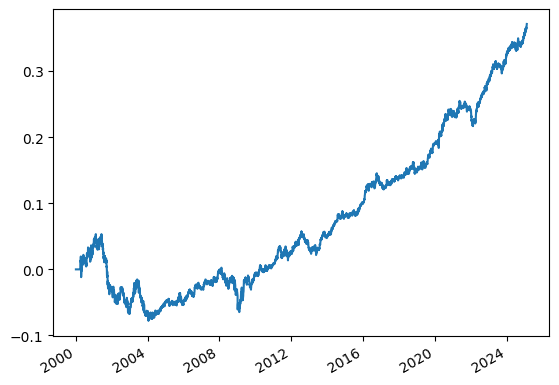

In [145]:
df_factor1 = pd.read_pickle(output_path + 'topix500_usd_5m_adv_factor1_weights_20250213.pkl')
df_factor2 = pd.read_pickle(output_path + 'topix500_usd_5m_adv_factor2_weights_20250213.pkl')
df_factor3 = pd.read_pickle(output_path + 'topix500_usd_5m_adv_factor3_weights_20250213.pkl')

# 5-day lagging
# 0.33 | 0.33 | 0.2830 0.8147, 0.0714, -0.0898
# 0.5 | 0.25 | 0.25 0.2209, 0.0145, -0.0980
# 0.25 | 0.5 | 0.25 0.3723, 0.1724, -0.0324
# 0.25 | 0.25 | 0.5 0.2384, 0.0196, -0.1384

# 3-day lagging
# 0.33 | 0.33 | 0.33 0.6048, 0.6422, 0.5402
# 0.5 | 0.25 | 0.25 0.5392, 0.6273, 0.5730
# 0.25 | 0.5 | 0.25 0.6355, 0.6407, 0.5038
# 0.25 | 0.25 | 0.5 0.6109, 0.6257, 0.5190

# 2-day lagging
# 0.33 | 0.33 | 0.33 0.8147, 0.9641, 0.9688
# 0.5 | 0.25 | 0.25 0.7367, 0.9429, 0.9764
# 0.25 | 0.5 | 0.25 0.8983, 0.9687, 0.9368
# 0.25 | 0.25 | 0.5 0.7682, 0.9324, 0.9496

# 1-day lagging
# 0.33 | 0.33 | 0.33 0.9275, 1.2130, 1.3411
# 0.5 | 0.25 | 0.25 0.7998, 1.1621, 1.3492
# 0.25 | 0.5 | 0.25 1.0174, 1.1746, 1.2868
# 0.25 | 0.25 | 0.5 0.9193, 1.2464, 1.3285

common_dates = df_factor1.index \
.intersection(df_factor2.index) \
.intersection(df_factor3.index)

df_factor1 = df_factor1.loc[common_dates]
df_factor2 = df_factor2.loc[common_dates]
df_factor3 = df_factor3.loc[common_dates]

common_dates = df_usd_return.index.intersection(df_factor1.index)
df_factor1 = df_factor1.loc[common_dates]
df_usd_return_filtered = df_usd_return.loc[common_dates]
df_usd_return_filtered, df_factor1 = build_same_setting_dataframe(df_usd_return_filtered, df_factor1)
df_factor1_return = calc_portfolio_return(df_usd_return_filtered, df_factor1, 1)

common_dates = df_usd_return.index.intersection(df_factor2.index)
df_factor2 = df_factor2.loc[common_dates]
df_usd_return_filtered = df_usd_return.loc[common_dates]
df_usd_return_filtered, df_factor2 = build_same_setting_dataframe(df_usd_return_filtered, df_factor2)
df_factor2_return = calc_portfolio_return(df_usd_return_filtered, df_factor2, 1)

common_dates = df_usd_return.index.intersection(df_factor3.index)
df_factor3 = df_factor3.loc[common_dates]
df_usd_return_filtered = df_usd_return.loc[common_dates]
df_usd_return_filtered, df_factor3 = build_same_setting_dataframe(df_usd_return_filtered, df_factor3)
df_factor3_return = calc_portfolio_return(df_usd_return_filtered, df_factor3, 1)

df_weights = 0.3333 * df_factor1 \
            + 0.3333 * df_factor2 \
            + 0.3333 * df_factor3

common_dates = df_usd_return.index.intersection(df_weights.index)
df_weights = df_weights.loc[common_dates]
df_usd_return_filtered = df_usd_return.loc[common_dates]

df_usd_return_filtered, df_weights = build_same_setting_dataframe(df_usd_return_filtered, df_weights)
df_portfolio_return = calc_portfolio_return(df_usd_return_filtered, df_weights, 1)

((df_portfolio_return['return'] + 1).cumprod() - 1).plot()
print((df_portfolio_return.loc[datetime.strptime('20050101','%Y%m%d'):]['return'].mean()*250) / (df_portfolio_return.loc[datetime.strptime('20050101','%Y%m%d'):]['return'].std() * np.sqrt(250)))
print((df_portfolio_return.loc[datetime.strptime('20100101','%Y%m%d'):]['return'].mean()*250) / (df_portfolio_return.loc[datetime.strptime('20100101','%Y%m%d'):]['return'].std() * np.sqrt(250)))
print((df_portfolio_return.loc[datetime.strptime('20150101','%Y%m%d'):]['return'].mean()*250) / (df_portfolio_return.loc[datetime.strptime('20150101','%Y%m%d'):]['return'].std() * np.sqrt(250)))

# Number of Holdings 

<Axes: >

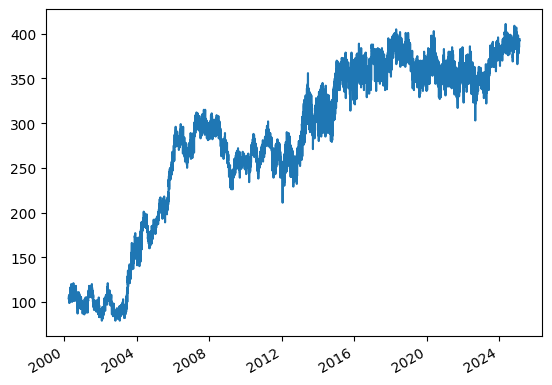

In [146]:
df_weights_filtered = df_weights.dropna(how='all')
df_weights_count = (df_weights_filtered != 0).astype(int).sum(axis=1) 
df_weights_count.plot()

# Portfolio Weight

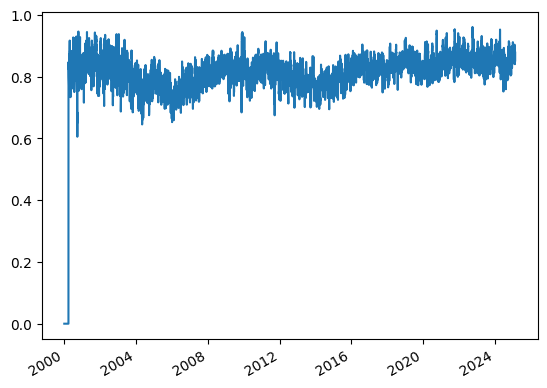

In [147]:
df_portfolio_weights = df_weights.abs().sum(axis=1).plot()

# Portfolio Turnover

0.33544574047211917


<Axes: >

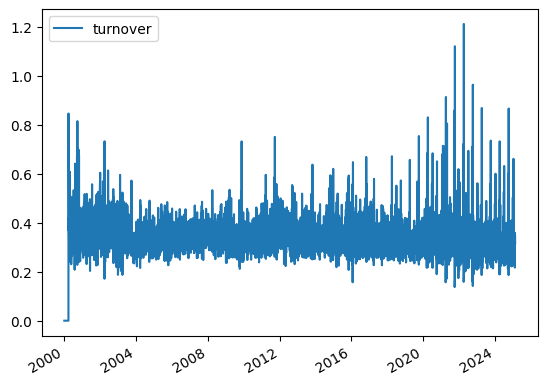

In [148]:
df_turnover = df_weights.fillna(0).diff().abs().sum(axis=1)
df_turnover = pd.DataFrame(df_turnover, columns = ['turnover'])
print(df_turnover['turnover'].mean())
df_turnover.plot()